# CIIC5015 - Introduction to Artificial Intelligence
## Project 2 - Fully Connected Neural Networks
### Part 2 - Classification

Fernando J. Bermudez Medina - 802-18-0426

Import the necesary libraries & Classes
- Matplotlib
- NumPy
- PyTorch
    - `Dataset` & `DataLoader` to pre-process data
    - `TorchVision` to normalize data
    - `TorchInfo` to view information about the neural networks defined 

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

### Download, Load & Normalize the MNIST Dataset

To fetch the data to use for training & testing, we will use the PyTorch's torchvision framework. In here we have a dataset that contains the MNIST Dataset and we can load it in the DataLoaders to split it into `batch_size` batches. We normalize the datasets using the mean & standard deviation using Torchvision's `transforms.Compose` class. The class uses the Z-Score normalization of thr following form:

$$Z = \frac{x - \mu}{\sigma}$$

In [24]:
mean, std = 0.1307, 0.3081 # 0.1307 & 0.3081 are the mean and std of MNIST dataset
transform = torchvision.transforms.Compose(
    [
        transforms.ToTensor(),
         transforms.Normalize((mean,), (std,)) 
    ]
)

batch_size = 100

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

classes = [i for i in range(0, 10)]

### Vizualize the data and its corresponding Tensor shapes

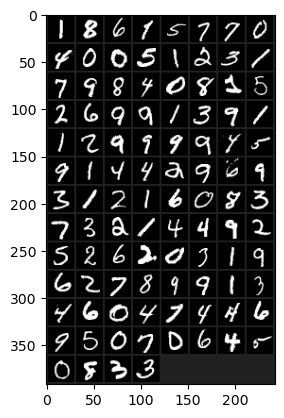

1 8 6 1 5 7 7 0 4 0 0 5 1 2 3 1 7 9 8 4 0 8 1 5 2 6 9 9 1 3 9 1 1 2 9 9 9 9 4 5 9 1 4 4 2 9 6 9 3 1 2 1 6 0 8 3 7 3 2 1 4 4 9 2 5 2 6 2 0 3 1 9 6 2 7 8 9 9 1 3 4 6 0 4 7 4 4 6 9 5 0 7 0 6 4 5 0 8 3 3
Images Batch Shape: torch.Size([100, 1, 28, 28])
Single Image Shape: torch.Size([1, 28, 28])
Flattened Single Image Shape: torch.Size([784])
Flattened Batch Shape: torch.Size([100, 784])


In [25]:
def show_image(image):
    unnormalized_image = (image * std) + mean
    image_array = unnormalized_image.numpy()
    plt.imshow(np.transpose(image_array, (1,2,0)))
    plt.show()
    
image_batch, label_batch = next(iter(train_data_loader))
show_image(torchvision.utils.make_grid(image_batch))
print(' '.join(f"{classes[label_batch[j]]}" for j in range(batch_size)))

print(f'Images Batch Shape: {image_batch.shape}') # (batch_size number of images, 1 color channel, 28 x 28 pixels)
print(f'Single Image Shape: {image_batch[0].shape}') # (1 color channel, 28 x 28 pixels)
print(f'Flattened Single Image Shape: {image_batch[0].view(-1).shape}') # (28 x 28 = 784 pixels)

flattened_batch = image_batch.view(-1, 784)

print(f"Flattened Batch Shape: {flattened_batch.shape}") # 4 tensors of 784 features (or pixels)


### Create Classification Neural Network Models

Using PyTorch's `nn.Linear` & `nn.ReLU` classes, we can create a classification  model that has one input layer, 3 hidden layers and one output layer. All of the layes have ReLU activation, except the output layer which has Softmax acitvation. We also create 2 extra models that contain 6 layers each (1 input, 4 hidden, 1 output). Each layer is stored inside an instance of `torch.nn.Sequential`.

In [26]:
class ClassificationModel1(torch.nn.Module):
    def __init__(self,input_size):
        super(ClassificationModel1, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
        )
        
    def forward(self, x):
        flattened_x = x.view(-1, 784)
        return self.layers(flattened_x)
        
class ClassificationModel2(torch.nn.Module):
    def __init__(self,input_size):
        super(ClassificationModel2, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
        )
        
    def forward(self, x):
        flattened_x = x.view(-1, 784)
        return self.layers(flattened_x)

class ClassificationModel3(torch.nn.Module):
    def __init__(self,input_size):
        super(ClassificationModel3, self).__init__()
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 70),
            torch.nn.ReLU(),
            torch.nn.Linear(70, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 10),
        )
        
        
    def forward(self, x):
        flattened_x = x.view(-1, 784)
        return self.layers(flattened_x)

### Define Functions to Train, Compute Accuracy & Plot Loss Values

Once we define the model and its hyperparameters, we can define the loop used for training. 

The algorithm follows the following pseudocode:

```
for an n number of epochs, do the following:
    for each batch in train_loader:
        reset gradients to 0
        make a prediction (forward pass)
        compute loss value for that prediction
        back propagate error to all neurons (backward pass)
        adjust gradients based on error and back propagation
        compute average batch loss and store it for plotting
```

Now, we take the batch loss values collected from our training process to see if the loss converged (or plateaued) to a certain value in each model.

To do this, we define two functions to help us visualize the data better using `Matplotlib.pyplot`
- `plot_loss(loss_list, n)`:
    - The method takes as parameter the lists of batch loss values from a number of networks `n` and plots them. The x axis represents the epoch, the y value the average batch loss of hte networks
- `accuracy(model, nn)`:
    - The method takes as parameter the network to test, a number indicating what network it is (1, 2, 3) and computes how many predcitions it classified correctly.

In [27]:
def train_model(neural_network, epochs, learning_rate, network):
    print(f"Starting Neural Network {network} training")
    loss_list = []
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(neural_network.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for index, data in enumerate(train_data_loader, 0):
            input_images, label_images = data
            
            optimizer.zero_grad()
            
            predictions = neural_network(input_images)
            loss = criterion(predictions, label_images)
            
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
    
            if (index + 1) % 600 == 0:
                print(f"Epoch: {epoch + 1}\tTotal Batch Images: {index + 1:5d}\tAverage Batch Loss: {running_loss / 600:.3f}")
                loss_list.append(running_loss / 600)
                running_loss = 0.0
                
                
    print(f"Finished Neural Network {network} training")
    return loss_list

def accuracy(neural_network, nn):
    correct = 0
    total = 0 
    
    with torch.no_grad():
        for data in test_data_loader:
            images, labels = data
            
            prediction = neural_network(images)
            
            _, predicted = torch.max(prediction.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f"Accuracy of Neural Network {nn}: {100 * correct // total}%")

def plot_loss(loss_list, nn):
    plt.plot(loss_list, 'r' if nn == 1 else 'b' if nn == 2 else 'g', label=f"Neural Network {nn}") # Plot the loss function in red color

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, color='grey')
    plt.show()

### Train Neural Network Models

In [28]:
neural_network1 = ClassificationModel1(784)
nn1_loss = train_model(neural_network=neural_network1, epochs=20, learning_rate=0.01, network=1)

Starting Neural Network 1 training
Epoch: 1	Total Batch Images:   600	Average Batch Loss: 0.359
Epoch: 2	Total Batch Images:   600	Average Batch Loss: 0.222
Epoch: 3	Total Batch Images:   600	Average Batch Loss: 0.196
Epoch: 4	Total Batch Images:   600	Average Batch Loss: 0.186
Epoch: 5	Total Batch Images:   600	Average Batch Loss: 0.181
Epoch: 6	Total Batch Images:   600	Average Batch Loss: 0.173
Epoch: 7	Total Batch Images:   600	Average Batch Loss: 0.168
Epoch: 8	Total Batch Images:   600	Average Batch Loss: 0.165
Epoch: 9	Total Batch Images:   600	Average Batch Loss: 0.162
Epoch: 10	Total Batch Images:   600	Average Batch Loss: 0.161
Epoch: 11	Total Batch Images:   600	Average Batch Loss: 0.154
Epoch: 12	Total Batch Images:   600	Average Batch Loss: 0.157
Epoch: 13	Total Batch Images:   600	Average Batch Loss: 0.151
Epoch: 14	Total Batch Images:   600	Average Batch Loss: 0.146
Epoch: 15	Total Batch Images:   600	Average Batch Loss: 0.150
Epoch: 16	Total Batch Images:   600	Average 

In [29]:
neural_network2 = ClassificationModel2(784)
nn2_loss = train_model(neural_network=neural_network2, epochs=20, learning_rate=0.01, network=2)

Starting Neural Network 2 training
Epoch: 1	Total Batch Images:   600	Average Batch Loss: 0.767
Epoch: 2	Total Batch Images:   600	Average Batch Loss: 0.468
Epoch: 3	Total Batch Images:   600	Average Batch Loss: 0.400
Epoch: 4	Total Batch Images:   600	Average Batch Loss: 0.389
Epoch: 5	Total Batch Images:   600	Average Batch Loss: 0.370
Epoch: 6	Total Batch Images:   600	Average Batch Loss: 0.364
Epoch: 7	Total Batch Images:   600	Average Batch Loss: 0.354
Epoch: 8	Total Batch Images:   600	Average Batch Loss: 0.349
Epoch: 9	Total Batch Images:   600	Average Batch Loss: 0.346
Epoch: 10	Total Batch Images:   600	Average Batch Loss: 0.345
Epoch: 11	Total Batch Images:   600	Average Batch Loss: 0.344
Epoch: 12	Total Batch Images:   600	Average Batch Loss: 0.339
Epoch: 13	Total Batch Images:   600	Average Batch Loss: 0.337
Epoch: 14	Total Batch Images:   600	Average Batch Loss: 0.339
Epoch: 15	Total Batch Images:   600	Average Batch Loss: 0.338
Epoch: 16	Total Batch Images:   600	Average 

In [30]:
neural_network3 = ClassificationModel3(784)
nn3_loss = train_model(neural_network=neural_network3, epochs=20, learning_rate=0.01, network=3)

Starting Neural Network 3 training
Epoch: 1	Total Batch Images:   600	Average Batch Loss: 0.486
Epoch: 2	Total Batch Images:   600	Average Batch Loss: 0.338
Epoch: 3	Total Batch Images:   600	Average Batch Loss: 0.319
Epoch: 4	Total Batch Images:   600	Average Batch Loss: 0.305
Epoch: 5	Total Batch Images:   600	Average Batch Loss: 0.296
Epoch: 6	Total Batch Images:   600	Average Batch Loss: 0.291
Epoch: 7	Total Batch Images:   600	Average Batch Loss: 0.287
Epoch: 8	Total Batch Images:   600	Average Batch Loss: 0.284
Epoch: 9	Total Batch Images:   600	Average Batch Loss: 0.279
Epoch: 10	Total Batch Images:   600	Average Batch Loss: 0.285
Epoch: 11	Total Batch Images:   600	Average Batch Loss: 0.282
Epoch: 12	Total Batch Images:   600	Average Batch Loss: 0.276
Epoch: 13	Total Batch Images:   600	Average Batch Loss: 0.272
Epoch: 14	Total Batch Images:   600	Average Batch Loss: 0.270
Epoch: 15	Total Batch Images:   600	Average Batch Loss: 0.278
Epoch: 16	Total Batch Images:   600	Average 

### Test Model Accuracy & Plot Loss Values

Accuracy of Neural Network 1: 95%


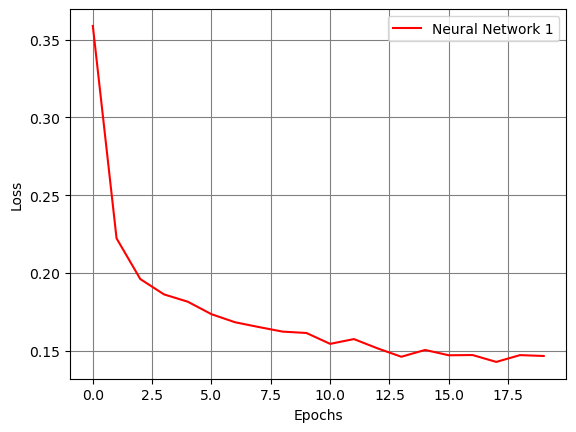

Accuracy of Neural Network 2: 89%


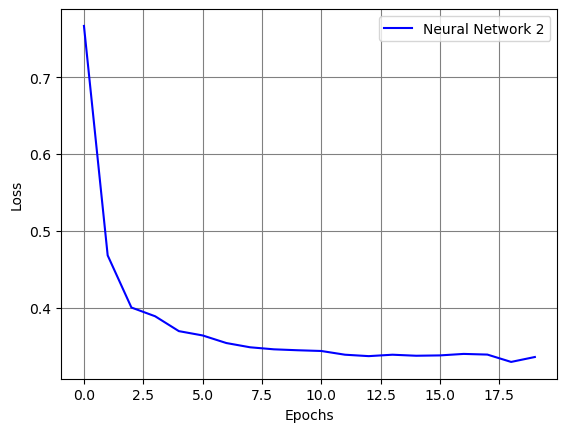

Accuracy of Neural Network 3: 91%


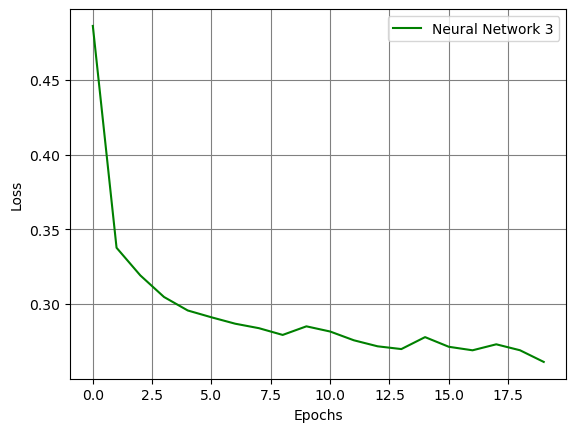

In [31]:
accuracy(neural_network1, 1)
plot_loss(nn1_loss, 1)

accuracy(neural_network2, 2)
plot_loss(nn2_loss, 2)

accuracy(neural_network3, 3)
plot_loss(nn3_loss, 3)

### Conclusions

Following the process done in this notebook, we can answer the following two questions:

1. Which of the three models had the least amount of error for validation? 
    - From the three models, we can see that each model only has a minimal difference in accuracy, and all 3 models have the same loss values and they converge almost to the same value. The only model that stands out in terms of accuracy is model 1 since it always contains a constant value of around 90-95%, but a fraction larger than model 3. In conclusion, model 1 is the one with the least amoun of error for validation.
2. How long it took to train each model? 
    - Each model takes around 5 minutes to train since it is processing 600 images per batch, comapred to regression, it is expected to take more time, considering it is a lot more data and these models are not using the GPU to make the computations necesarry to make the loss converge.